In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import rasterio as rio
from rasterio.plot import show
import glob
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tifffile
from skimage import color, io
import time
import warnings
from tqdm import tqdm
import math
import tifffile as tiff

In [19]:
swir_st = pd.read_csv('Normalization/bands_distribution/swir_distribution.csv')
nir_st = pd.read_csv('Normalization/bands_distribution/nir_distribution.csv')
red_st = pd.read_csv('Normalization/bands_distribution/red_distribution.csv')
green_st = pd.read_csv('Normalization/bands_distribution/green_distribution.csv')
blue_st = pd.read_csv('Normalization/bands_distribution/blue_distribution.csv')
dem_st = pd.read_csv('Normalization/bands_distribution/dem_distribution.csv')
dist_st = pd.read_csv('Normalization/bands_distribution/dist_distribution.csv')
ndvi_st = pd.read_csv('Normalization/bands_distribution/ndvi_distribution.csv')
mndwi_st = pd.read_csv('Normalization/bands_distribution/mndwi_distribution.csv')

In [11]:
swir_st = swir_st[swir_st['px_val'] != -32768]
nir_st = nir_st[nir_st['px_val'] != -32768]
red_st = red_st[red_st['px_val'] != -32768]
green_st = green_st[green_st['px_val'] != -32768]
blue_st = blue_st[blue_st['px_val'] != -32768]

In [5]:
def plot_dist(df):

    pixel_values = df['px_val'].tolist()
    frequencies = df['num_pxs'].tolist()

    # Use numpy.repeat to create the numpy array with repeated values
    list_df= np.repeat(pixel_values, frequencies)
    print(len(list_df))
    lower_percentile = np.percentile(list_df, 5)
    upper_percentile = np.percentile(list_df, 95)

    # Plot the bar graph
    plt.hist(list_df, bins=100)
    plt.xlabel('Px val')
    plt.ylabel('Number of Pixels')
    plt.title(f'Total distribution of Pixels per value')
    plt.yscale('linear')  # Set y-axis to logarithmic scale
    plt.xscale('linear')  # Set x-axis to linear scale
    plt.xlim([0, 60000])  # Set x-axis limits

    # Add vertical lines for the 5% upper and lower percentiles
    plt.axvline(lower_percentile, color='red', linestyle='dashed', linewidth=2, label='Lower 5%')
    plt.axvline(upper_percentile, color='red', linestyle='dashed', linewidth=2, label='Upper 5%')

    # Show the legend
    plt.legend()

379981421


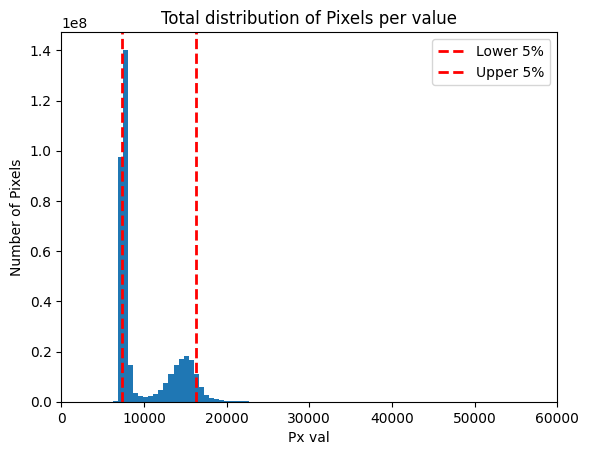

In [28]:
plot_dist(swir_st)

379980204


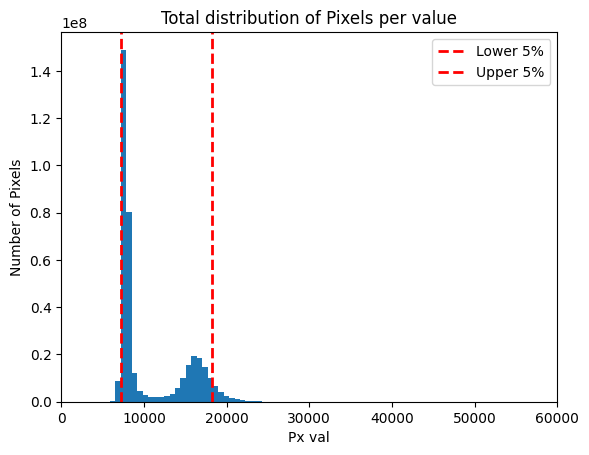

In [29]:
plot_dist(nir_st)

In [7]:
plot_dist(red_st)

NameError: name 'plot_dist' is not defined

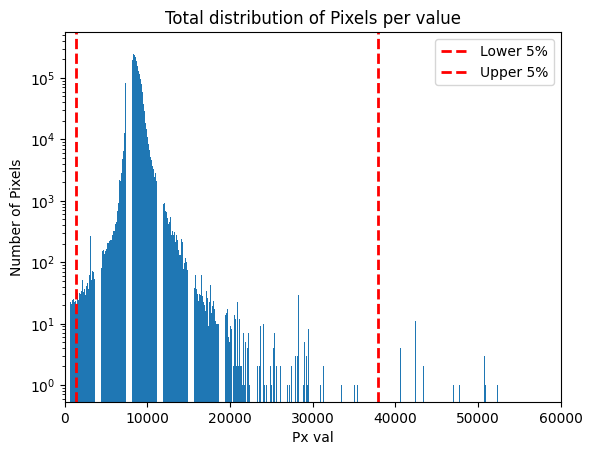

In [17]:
plot_dist(blue_st)

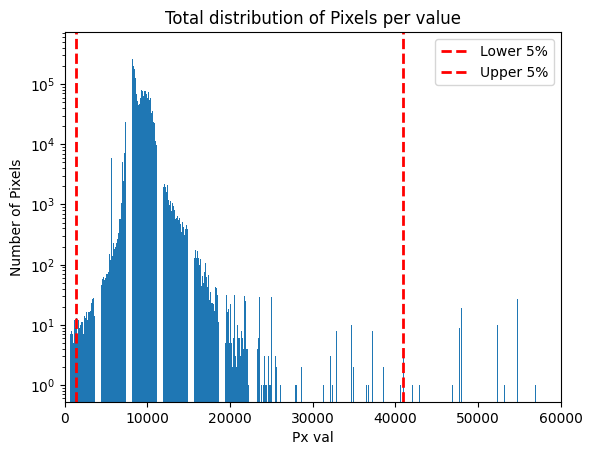

In [18]:
plot_dist(green_st)

In [3]:
def plot_dist_dem(df):

    # Calculate the 5% upper and lower percentiles
    lower_percentile = np.percentile(df['num_pxs'], 5)
    upper_percentile = np.percentile(df['num_pxs'], 95)

   # Plot the bar graph
    plt.bar(df['px_val'], df['num_pxs'])
    plt.xlabel('Px val')
    plt.ylabel('Number of Pixels')
    plt.title(f'Total distribution of Pixels per DEM value')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.xscale('linear')  # Set x-axis to linear scale
    plt.xlim([0, 700])  # Set x-axis limits
    # Add vertical lines for the 5% upper and lower percentiles
    plt.axvline(lower_percentile, color='red', linestyle='dashed', linewidth=2, label='Lower 5%')
    plt.axvline(upper_percentile, color='red', linestyle='dashed', linewidth=2, label='Upper 5%')


    # Show the legend
    plt.legend()


In [8]:
dem_max = dem_st['px_val'].max()
print(f'max DEM val: {dem_max}')

max DEM val: 650


In [46]:
def get_stats(df, perc):
    if perc == 'lowup5':
        lower_percentile = np.percentile(df['px_val'], 5)
        upper_percentile = np.percentile(df['px_val'], 95)

        filtered_df = df[(df['px_val'] >= lower_percentile) & (df['px_val'] <= upper_percentile)]

    elif perc == 'up10':
        upper_percentile = np.percentile(df['px_val'], 90)
        filtered_df = df[(df['px_val'] <= upper_percentile)] 
    
    elif perc == 'none':
        filtered_df = df

    df_np = filtered_df.to_numpy()

    # 0: x (px_val)
    # 1: freq (num of values)

    # 2: x^2
    df_np = np.column_stack((df_np, df_np[:,0]**2))

    # 3: freq * x
    df_np = np.column_stack((df_np, df_np[:,0]* df_np[:,1]))

    # 4: freq * x^2
    df_np = np.column_stack((df_np, df_np[:,1]* df_np[:,2]))

    sum_f = np.sum(df_np[:, 1])

    sum_fx = np.sum(df_np[:, 3])

    sum_fxsq = np.sum(df_np[:, 4])

    mean = sum_fx/sum_f

    # 5: x - mean
    df_np = np.column_stack((df_np, df_np[:,0] - mean))

    # 6: (x - mean**2)
    df_np = np.column_stack((df_np, (df_np[:,5])**2))

    # 7: freq* (x-mean)**2
    df_np = np.column_stack((df_np, (df_np[:,6])*df_np[:,1]))

    sum_col7 = np.sum(df_np[:, 7])

    #std = math.sqrt((sum_fxsq/sum_f)-mean)
    std = math.sqrt(sum_col7/(sum_f-1))

    return df_np, mean, std

### EXPORTING SPECTRAL BANDS STATS

In [35]:
sw_nump, sw_mean, sw_std = get_stats(swir_st)
n_nump, n_mean, n_std = get_stats(nir_st)
r_nump, r_mean, r_std = get_stats(red_st)
g_nump, g_mean, g_std = get_stats(green_st)
b_nump, b_mean, b_std = get_stats(blue_st)

TypeError: get_stats() missing 1 required positional argument: 'perc'

In [23]:
print(sw_std)
print(n_std)
print(r_std)
print(g_std)
print(b_std)

3473.127623301318
4193.980716822915
1296.7961477456688
1105.190361688571
763.9614936190823


In [7]:
stds = np.array([sw_std, n_std, r_std, g_std, b_std])
means = np.array([sw_mean, n_mean, r_mean, g_mean, b_mean])

np.savez('norm_stats_wo_up10_perc.npz', stds=stds, means=means)

NameError: name 'sw_std' is not defined

### EXPORTING DEM STATS

In [50]:
dem_nump, dem_mean, dem_std = get_stats(dem_st, perc='none')

In [52]:
print(dem_std)
print(dem_mean)

523.9007998940268
4.766595510588778


In [53]:
stds = np.array([dem_std])
means = np.array([dem_mean])

np.savez('norm_stats_dem_totaldist.npz', stds=stds, means=means)

### EXPORTING DISTANCE MAP STATS

In [47]:
dist_nump, dist_mean, dist_std = get_stats(dist_st, perc='none')

In [48]:
print(dist_std)
print(dist_mean)

83.08044704896467
54.08297306789466


In [49]:
stds = np.array([dist_std])
means = np.array([dist_mean])

np.savez('norm_stats_dist_totaldist.npz', stds=stds, means=means)

## GETTING STATS FROM COMPLETE DISTRIBUTION (NOT FREQUENCY)

In [11]:
def get_stats_v2(df, perc):
    pixel_values = df['px_val'].tolist()
    frequencies = df['num_pxs'].tolist()
    list_df= np.repeat(pixel_values, frequencies)
    print(len(list_df))

    if perc == 'lowup5':
        lower_percentile = np.percentile(list_df, 5)
        upper_percentile = np.percentile(list_df, 95)

        filtered_df = list_df[(list_df >= lower_percentile) & (list_df <= upper_percentile)]

    elif perc == 'up10':
        upper_percentile = np.percentile(list_df, 90)
        filtered_df = list_df[list_df <= upper_percentile] 
    
    elif perc == 'none':
        filtered_df = list_df

    mean = np.mean(list_df)
    std = np.std(list_df)

    return mean, std

In [33]:
sw_mean, sw_std = get_stats_v2(swir_st, 'lowup5')
n_mean, n_std = get_stats_v2(nir_st, 'lowup5')
r_mean, r_std = get_stats_v2(red_st, 'lowup5')
g_mean, g_std = get_stats_v2(green_st, 'lowup5')
b_mean, b_std = get_stats_v2(blue_st, 'lowup5')

379981421
379980204
379966465
379966382
379910278


In [34]:
print(sw_std)
print(n_std)
print(r_std)
print(g_std)
print(b_std)

3476.4264043885787
4203.905909459553
1321.2143919461541
1129.9842243051398
792.2012131961435


In [35]:
stds = np.array([sw_std, n_std, r_std, g_std, b_std])
means = np.array([sw_mean, n_mean, r_mean, g_mean, b_mean])

np.savez('norm_stats_wo_low5_up5_perc_20240214.npz', stds=stds, means=means)

## NDVI STATS

389795000


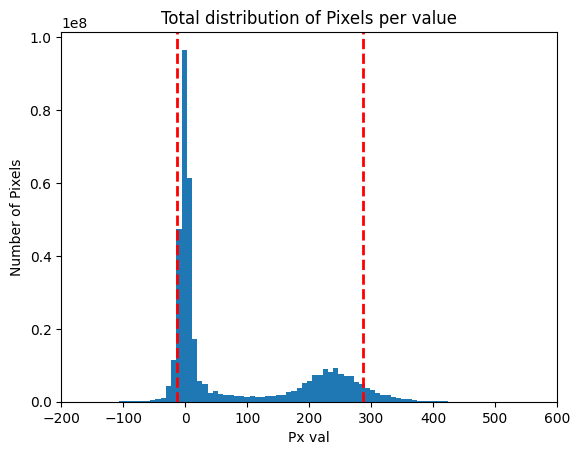

In [20]:
df=ndvi_st

pixel_values = df['px_val'].tolist()
frequencies = df['num_pxs'].tolist()

# Use numpy.repeat to create the numpy array with repeated values
list_df= np.repeat(pixel_values, frequencies)
print(len(list_df))
lower_percentile = np.percentile(list_df, 5)
upper_percentile = np.percentile(list_df, 95)

# Plot the bar graph
plt.hist(list_df, bins=1000)
plt.xlabel('Px val')
plt.ylabel('Number of Pixels')
plt.title(f'Total distribution of Pixels per value')
plt.yscale('linear')  # Set y-axis to logarithmic scale
plt.xscale('linear')  # Set x-axis to linear scale
plt.xlim([-200, 600])  # Set x-axis limits

# Add vertical lines for the 5% upper and lower percentiles
plt.axvline(lower_percentile, color='red', linestyle='dashed', linewidth=2, label='Lower 5%')
plt.axvline(upper_percentile, color='red', linestyle='dashed', linewidth=2, label='Upper 5%')


In [13]:
ndvi_mean, ndvi_std = get_stats_v2(ndvi_st, 'lowup5')

389795000


In [15]:
print(ndvi_std)

114.60573980377598


In [16]:
stds = np.array(ndvi_std)
means = np.array(ndvi_mean)

np.savez('norm_stats_ndvi_wo_low5_up5_perc.npz', stds=stds, means=means)

In [7]:
ndvi_st = np.load('Normalization/Norm_stats/norm_stats_ndvi_wo_low5_up5_perc.npz')
st_arr = ndvi_st['stds']
mean_arr = ndvi_st['means']
print(st_arr)
print(mean_arr)

means = mean_arr /1000

stds = st_arr /1000

print(stds)
print(means)

114.60573980377598
76.72012517605408
0.11460573980377597
0.07672012517605409


In [6]:
np.savez('norm_stats_ndvi_wo_low5_up5_perc_v2.npz', stds=stds, means=means)

## MNDWI STATS

389795000


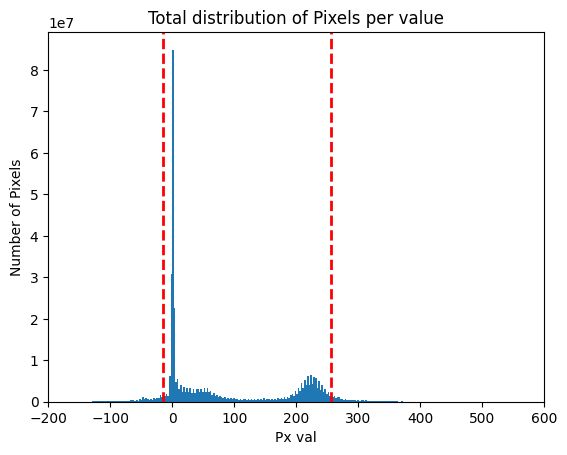

In [21]:
df=mndwi_st

pixel_values = df['px_val'].tolist()
frequencies = df['num_pxs'].tolist()

# Use numpy.repeat to create the numpy array with repeated values
list_df= np.repeat(pixel_values, frequencies)
print(len(list_df))
lower_percentile = np.percentile(list_df, 5)
upper_percentile = np.percentile(list_df, 95)

# Plot the bar graph
plt.hist(list_df, bins=1000)
plt.xlabel('Px val')
plt.ylabel('Number of Pixels')
plt.title(f'Total distribution of Pixels per value')
plt.yscale('linear')  # Set y-axis to logarithmic scale
plt.xscale('linear')  # Set x-axis to linear scale
plt.xlim([-200, 600])  # Set x-axis limits

# Add vertical lines for the 5% upper and lower percentiles
plt.axvline(lower_percentile, color='red', linestyle='dashed', linewidth=2, label='Lower 5%')
plt.axvline(upper_percentile, color='red', linestyle='dashed', linewidth=2, label='Upper 5%')